# Named entity recognition

The exercise shows how we may extract elements such as names of companies, countries and similar objects from text.

## Tasks

Objectives (8 points):

1. Read the API of [NER](https://spacy.io/api/entityrecognizer) in Spacy

2. Take 1 thousand random passages from the FIQA-PL corpus.

In [15]:
from datasets import load_dataset
import pandas as pd
import numpy as np

def modify_df(df, labels):
    for label in labels:
        if label[0] == '_':
            df = df.rename(columns={label: label[1:]})
            label = label[1:]
        df[label] = df[label].astype(np.int64)
    return df

ds = load_dataset("clarin-knext/fiqa-pl", "corpus")
df_corpus = pd.DataFrame(ds['corpus'])
df_corpus = modify_df(df_corpus, ['_id'])
print(df_corpus.head())

ds_q = load_dataset("clarin-knext/fiqa-pl", "queries")
ds_q = pd.DataFrame(ds_q['queries'])
ds_q = modify_df(ds_q, ['_id'])
print(ds_q.head())

ds_qrels = load_dataset("clarin-knext/fiqa-pl-qrels")
df_qrels = pd.DataFrame(ds_qrels['train'])
df_qrels_test = pd.DataFrame(ds_qrels['test'])
df_qrels = modify_df(df_qrels, ['query-id', 'corpus-id', 'score'])
df_qrels_test = modify_df(df_qrels_test, ['query-id', 'corpus-id', 'score'])
print(df_qrels.head())
print(df_qrels_test.head())


   id title                                               text
0   3        Nie mówię, że nie podoba mi się też pomysł szk...
1  31        Tak więc nic nie zapobiega fałszywym ocenom po...
2  56        Nigdy nie możesz korzystać z FSA dla indywidua...
3  59        Samsung stworzył LCD i inne technologie płaski...
4  63        Oto wymagania SEC: Federalne przepisy dotycząc...
   id title                                               text
0   0        Co jest uważane za wydatek służbowy w podróży ...
1   4        Wydatki służbowe - ubezpieczenie samochodu pod...
2   5                        Rozpoczęcie nowego biznesu online
3   6           „Dzień roboczy” i „termin płatności” rachunków
4   7        Nowy właściciel firmy – Jak działają podatki d...
   query-id  corpus-id  score
0         0      18850      1
1         4     196463      1
2         5      69306      1
3         6     560251      1
4         6     188530      1
   query-id  corpus-id  score
0         8     566392      1
1   

In [16]:
ds_q_mapper = dict()
ds_corpus_mapper = dict()

for idx, query in ds_q.iterrows():
    ds_q_mapper[query['id']] = query['text']

for idx, corpus in df_corpus.iterrows():
    ds_corpus_mapper[corpus['id']] = corpus['text']


print(ds_q_mapper[5993])

Dlaczego ktokolwiek miałby chcieć najpierw spłacić swoje długi w inny sposób niż „najwyższe odsetki”?


In [19]:
import random

corpus_ids = df_corpus["id"].tolist()
thousand_passages = dict()

while len(thousand_passages) < 1000:
    choice_id = random.choice(corpus_ids)
    passage = ds_corpus_mapper[choice_id]
    thousand_passages[choice_id] = passage

3. Use the lemmatized and sentence split documents (using SpaCy API for [lemmatization](https://spacy.io/api/lemmatizer) and [sentence splitting](https://spacy.io/api/sentencizer)) to identify the expressions that consist of consecutive
   words starting with a capital letter (you will have to look at the inflected form of the word to check its
   capitalization) that do not occupy the first position in a sentence. E.g. the sentence:
   ```
   Wczoraj w Krakowie miało miejsce spotkanie prezydentów Polski i Stanów Zjednoczonych.
   ```
   should yield the following entries: `Kraków`, `Polska`, `Stan Zjednoczony`.

In [20]:
import spacy
nlp = spacy.load('pl_core_news_md')
nlp.add_pipe("sentencizer")

def lookup_expressions(text, expressions_dict=None):
    docs = nlp(text)
    if expressions_dict is None:
        expressions_dict = dict()

    expression = ''
    last_capital = False
    for sent in docs.sents:
        for token in sent:
            if not token.is_sent_start:
                if token.lemma_[0].isupper():
                    if last_capital:
                        expression += ' '+token.lemma_
                    else:
                        expression += token.lemma_
                    last_capital = True
                else:
                    if last_capital:
                        if expression in expressions_dict:
                            expressions_dict[expression] += 1
                        else:
                            expressions_dict[expression] = 1
                        expression = ''
                    last_capital = False

    if last_capital:
        if expression in expressions_dict:
            expressions_dict[expression] += 1
        else:
            expressions_dict[expression] = 1

expressions_dict = dict()
lookup_expressions("Wczoraj w Krakowie miało miejsce spotkanie prezydentów Polski i Stanów Zjednoczonych.", expressions_dict=expressions_dict)
print(expressions_dict)

{'Kraków': 1, 'Polska': 1, 'Stany Zjednoczone': 1}


4. Compute the frequency of each identified expression and print 50 results with the largest number of occurrences.

In [21]:
expressions_dict = dict()

for passage in thousand_passages.values():
    lookup_expressions(passage, expressions_dict)

print(expressions_dict)

{'Baltimore': 2, 'Orlando': 1, 'Ciebie': 46, 'I': 2, 'Kanada': 13, 'Twojego': 13, 'Comcast': 11, 'BBB': 4, 'Twój': 45, 'Mastercard': 4, 'PMI': 5, 'ARM': 2, 'Odkładać': 1, 'Prosper': 5, 'Prosperze': 1, 'A': 11, 'AA': 2, 'Ustawa': 1, 'Twojej': 27, 'PKB USA': 1, 'Ameryka': 7, 'FP&A': 5, 'AP': 1, 'AR/': 1, 'GL': 1, 'SAP': 3, 'TY': 1, 'VA': 1, 'FHA': 3, 'GFE': 1, 'HUD': 1, 'Google': 21, 'SGA Furniture': 1, 'SGA': 1, 'Love Face Painting': 2, 'Melbourne': 1, 'Internet': 20, 'Le': 1, 'G': 2, 'LTE': 2, 'HSPA': 1, 'MF28D ZTE': 1, 'ZTE MF28D': 1, 'USA': 70, 'Admiral Share': 1, 'Vanguard': 5, 'Admiral': 1, 'Admiral Shares': 1, 'Capital Class': 1, 'Institutional': 1, 'FIPXX': 1, 'SEO': 1, 'SEO UT': 1, 'Część': 1, 'B': 17, 'IRS': 30, 'Harmonogram D': 2, 'Część II': 1, 'ODE': 1, 'Store': 1, 'Mastermind': 1, 'Of America': 1, 'MIC': 1, 'USD': 16, 'Visa': 5, 'BS': 3, 'Glassdoor': 2, 'TGIM': 2, 'Poniedziałek': 1, 'Summer Camp': 1, 'Amazon': 13, 'Apple': 13, 'Harmonogram A': 1, 'Sam': 2, 'Usuń': 1, 'Dołąc

In [22]:
ranking = list((v, k) for k, v in expressions_dict.items())
ranking = sorted(ranking, reverse=True)

for position in ranking[:50]:
    print(position)

(70, 'USA')
(48, 'IRA')
(46, 'Ciebie')
(45, 'Twój')
(38, 'Stany Zjednoczone')
(30, 'IRS')
(27, 'Twojej')
(25, 'Wielki Brytania')
(25, 'Indie')
(24, 'X')
(23, 'K')
(23, 'Chiny')
(21, 'PKB')
(21, 'Google')
(20, 'Internet')
(19, 'Roth')
(19, 'GBP')
(19, 'ETF')
(18, 'Facebook')
(18, 'CD')
(17, 'B')
(16, 'USD')
(15, 'Twoją')
(14, 'Twoich')
(14, 'S&P')
(14, 'Roth IRA')
(13, 'Twojego')
(13, 'PM')
(13, 'Kanada')
(13, 'Apple')
(13, 'Amazon')
(11, 'Comcast')
(11, 'A')
(10, 'Uber')
(10, 'C')
(10, 'Australia')
(9, 'Trump')
(9, 'Lyft')
(9, 'LLC')
(9, 'E')
(8, 'Walmart')
(8, 'RRSO')
(8, 'P')
(8, 'Opinie](http://np.reddit.com')
(8, 'FAQ](http://np.reddit.com')
(8, 'Cisco')
(8, 'Amazona')
(7, 'Stany')
(7, 'ROC')
(7, 'Nowy Jork')


5. Apply the NER from SpaCy to identify the named entities in the same set of documents.

In [23]:
classes_freq = dict()
classes_examples = dict(dict())

for passage in thousand_passages.values():
    docs = nlp(passage)
    for token in docs.ents:
        if token.label_ in classes_freq:
            classes_freq[token.label_] += 1
        else:
            classes_freq[token.label_] = 1
        if token.label_ in classes_examples:
            if token.lemma_ in classes_examples[token.label_]:
                classes_examples[token.label_][token.lemma_] += 1
            else:
                classes_examples[token.label_][token.lemma_] = 1
        else:
            classes_examples[token.label_] = dict()
            classes_examples[token.label_][token.lemma_] = 1

6. Plot the frequency (histogram) of the identified classes.

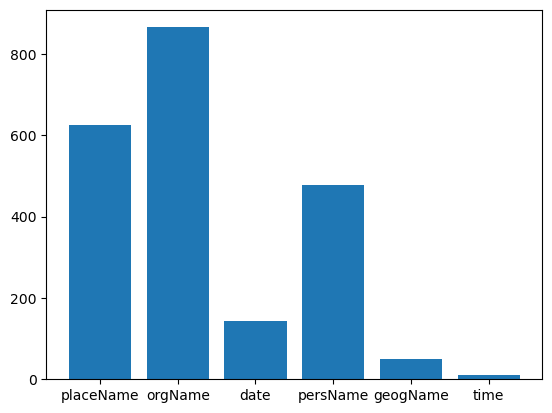

In [24]:
import matplotlib.pyplot as plt

plt.bar(classes_freq.keys(), classes_freq.values())
plt.show()

7. Display 10 most frequent Named Entities for each identified type.

In [25]:
for class_name, examples in classes_examples.items():
    print(class_name)
    print(sorted([(v, k) for k, v in examples.items()], reverse=True)[:10])
    print("===")

placeName
[(67, 'USA'), (49, 'amerykański'), (40, 'Stany Zjednoczone'), (25, 'Indie'), (24, 'Wielki Brytania'), (23, 'Chiny'), (13, 'Kanada'), (10, 'Australia'), (9, 'chiński'), (8, 'kanada')]
===
orgName
[(49, 'IRA'), (23, 'Google'), (18, 'ETF'), (15, 'Facebook'), (13, 'Roth IRA'), (11, 'Comcast'), (11, 'Apple'), (10, 'Microsoft'), (10, 'Cisco'), (8, 'bank')]
===
date
[(4, 'styczeń'), (4, '2014 rok.'), (4, '2014'), (3, '2017 rok.'), (3, '2016 rok'), (3, '2015'), (3, '2010 rok'), (3, '2008 rok'), (3, '2001 rok.'), (2, 'styczeń 2015 rok.')]
===
persName
[(14, 'Roth'), (12, 'Amazon'), (9, 'Trump'), (7, 'OP'), (7, 'Lyft'), (7, 'Bill'), (6, 'Walmart'), (6, 'Trumpa'), (4, '\u200b\u200bfirma'), (4, 'clearXchange')]
===
geogName
[(5, 'Europa'), (4, 'europejski'), (4, 'Wall Street'), (2, 'kanadyjski'), (2, 'blacklist/'), (2, 'Ziemia'), (2, 'Zachodni Brzeg'), (2, 'Ameryka'), (1, '\u200b\u200bwniosek'), (1, 'zachodni Brzeg')]
===
time
[(3, '65'), (1, 'godzina 18:00'), (1, 'godzina 16.'), (1, '6 

8. Display 50 most frequent Named Entities including their count and type.

In [36]:
all_examples = dict()

for class_name, examples in classes_examples.items():
    for example, count in examples.items():
        if example in all_examples:
            all_examples[example][0] += count
        else:
            all_examples[example] = [count, class_name]

for example in sorted([(v[0], v[1], k) for k, v in all_examples.items()], reverse=True)[:50]:
    print(example, )


(67, 'placeName', 'USA')
(49, 'placeName', 'amerykański')
(49, 'orgName', 'IRA')
(40, 'placeName', 'Stany Zjednoczone')
(25, 'placeName', 'Indie')
(24, 'placeName', 'Wielki Brytania')
(23, 'placeName', 'Chiny')
(23, 'orgName', 'Google')
(18, 'orgName', 'ETF')
(17, 'placeName', 'Roth')
(16, 'orgName', 'Amazon')
(15, 'orgName', 'Facebook')
(14, 'orgName', 'Apple')
(13, 'placeName', 'Kanada')
(13, 'orgName', 'Roth IRA')
(11, 'orgName', 'Comcast')
(10, 'placeName', 'Australia')
(10, 'orgName', 'Microsoft')
(10, 'orgName', 'Cisco')
(9, 'placeName', 'chiński')
(9, 'placeName', 'Walmart')
(9, 'persName', 'Trump')
(8, 'placeName', 'kanada')
(8, 'placeName', 'indyjski')
(8, 'orgName', 'bank')
(8, 'orgName', 'Lyft')
(7, 'placeName', 'nowy Jork')
(7, 'placeName', 'Nowy Jork')
(7, 'persName', 'OP')
(7, 'persName', 'Bill')
(7, 'orgName', 'Netflix')
(6, 'placeName', 'europejski')
(6, 'placeName', 'china')
(6, 'placeName', 'brytyjski')
(6, 'placeName', 'angielski')
(6, 'placeName', 'FICA')
(6, 'place

9. Display 5 sentences containing at least 2 recognized named entities with different types. Highlight the recognized spans with color.
   (For demo application [Streamlit](https://streamlit.io/) might be useful for displaying NER results).

In [34]:
from colorama import Fore

cnt_of_sentences = 5
sentences = []
for passage in thousand_passages.values():
    docs = nlp(passage)
    for sentence in docs.sents:
        label_dict = dict()
        text = list()
        for token in sentence.ents:
            if token.label_ in label_dict:
                label_dict[token.label_] += 1
            else:
                label_dict[token.label_] = 1
            text.append(token.text)
        
        if len(label_dict) > 1:
            sentences.append(sentence)
            sentence_text = sentence.text
            for txt in text:
                idx = sentence_text.find(txt)
                print(sentence_text[:idx], Fore.GREEN+txt+Fore.RESET, end='', sep='')
                sentence_text = sentence_text[idx+len(txt):]
            print()
            cnt_of_sentences -= 1
        
        if cnt_of_sentences == 0:
            break
    if cnt_of_sentences == 0:
        break

Kilka lat temu udzielałem pożyczek na Prosperze i trzymałem się głównie pożyczkobiorców, którzy mieli ocenę A lub AA przez Prospera
Modem lub router nie pasował do słynnego routera LTE w 2012 r. jako MF28D ZTE, możesz go usunąć z ZTE MF28D
Każdy poniedziałek był „TGIM” „Poniedziałek i każdy wydział odbywają spotkania po godzinie 18:00
Tam, gdzie sklep spożywczy mama i pop może uniknąć błędnego etykietowania tylko dlatego, że USDA/FDA może nie sprawdzić, czy nie jest to możliwe, myślę, że możemy być całkiem pewni, że Walmart
> W rzeczywistości wierzysz również, że „Rosjanie!” są odpowiedzialni za Trumpa, oprócz wszystkich okropnych rzeczy, w które wierzysz w Trumpa


In [28]:
import spacy_streamlit
import warnings

models = ["pl_core_news_md"]
visualizers = ["ner"]

for sentence in sentences:
    print(sentence)
    try:
        with warnings.catch_warnings(action="ignore"):
            spacy_streamlit.visualize_ner(sentence, labels=nlp.get_pipe("ner").labels, 
                                            colors={"orgName": "lightblue", 
                                                    "persName": "green", 
                                                    "placeName": "darkyellow", 
                                                    "geogName": "red", 
                                                    "date": "brown", 
                                                    "time": "purple"})
    except:
        pass

2024-12-07 22:26:53.500 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.501 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.501 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.502 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.502 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.503 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.504 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.504 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Kilka lat temu udzielałem pożyczek na Prosperze i trzymałem się głównie pożyczkobiorców, którzy mieli ocenę A lub AA przez Prospera, z których wielu okazało się być kompletnym martwym rytmem.


2024-12-07 22:26:53.509 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.510 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.510 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.511 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.511 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.512 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.512 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.513 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Modem lub router nie pasował do słynnego routera LTE w 2012 r. jako MF28D ZTE, możesz go usunąć z ZTE MF28D jako pomocnika genów upiększających odpowiedni opis.


2024-12-07 22:26:53.516 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.516 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.517 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.517 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.518 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.518 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.519 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.520 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Każdy poniedziałek był „TGIM” „Poniedziałek i każdy wydział odbywają spotkania po godzinie 18:00.


2024-12-07 22:26:53.524 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.525 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.525 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.526 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.526 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.527 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.527 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.528 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Tam, gdzie sklep spożywczy mama i pop może uniknąć błędnego etykietowania tylko dlatego, że USDA/FDA może nie sprawdzić, czy nie jest to możliwe, myślę, że możemy być całkiem pewni, że Walmart i inne główne sieci są często sprawdzane Aby uzyskać informacje o tym, co oznacza etykieta „„organiczna””, zajrzyj tutaj: http://www.usda.gov/wps/portal/usda/usdahome?navid=ORGANIC_CERTIFICATIO”


2024-12-07 22:26:53.533 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.533 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.534 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.534 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.534 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.535 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.535 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-07 22:26:53.536 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

> W rzeczywistości wierzysz również, że „Rosjanie!” są odpowiedzialni za Trumpa, oprócz wszystkich okropnych rzeczy, w które wierzysz w Trumpa.


Answer the following questions (2 points):

1. Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with
  identification of the proper names?\
  **Second method seems to have better outcome.\
    NER seeks also names starting with lower case letter and strives to find genuine names and important expressions. At the end it has better\ 
    results comparing to first method.**
2. What are the drawbacks of the method based on capital letters?\
  **First method is looking for every expression with capital letter, so sometimes it returns also basic words like "Twój", "Ciebie" or letter 'K'.\
      Probably there were also mistake where "Rozszerzone" was taken as an entity name.**
3. What are the drawbacks of the method based on NER?\
  **Returned basic number like '65' as time.\
    For type placeName, NER classified 'amerykański' as a place, but this is adjective that describes other item.\
    For type persName, NER classified 'Amazon' as a person, but it is a company.**
4. Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this
  observation.\
  **The best results are for orgName. NER returns real correct organization names.\
    The worst seems to have persName type, because the names sometimes are not people.**
5. Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and\
  "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej")? If not, can you suggest an algorithm or a tool that\
  would be able to group such names together?\
  **I don't think for NER 'USA' is the same as "Stany Zjednoczone". NER only can recognize it as an genuine name of entity, but it will be difficult for him to find connection between them.\
     Probably tool like Entity Linker with good knowledge base should work better or there have to be employed an elasticsearch with synonyms included.**
6. Can you think of a real world problem that would benefit the most from application of Named Entity Recognition
  algorithm?\
  **I believe finance domain where people deal with abundance of documents and have to scan articles or web pages for meaningful data like: prices, values, indicators, legal terms\
    famous changes on the market or transactions can benefit the most. NER is specialized for seeking such names and figures and can improve people's work.**